In [1]:
import pandas as pd
from pathlib import Path as path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Xtrain = pd.read_csv(path('../data/Xtrain.csv'))
Ytrain = pd.read_csv(path('../data/Ytrain.csv'))
Ytrain = Ytrain.loc[:, ~Ytrain.columns.str.contains('^Unnamed')]
TrainData = Xtrain
TrainData = TrainData.merge(Ytrain, left_index= True, right_index= True)
print(TrainData.info())
TrainData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB
None


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN,0.111
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN,0.143
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN,0.139
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN,0.117


In [15]:
_ = TrainData.copy()
_.date = pd.to_datetime(_.date,format='%Y-%M-%d')
_.date = _.date.dt.day_name()
_.date

0           Monday
1          Tuesday
2         Thursday
3           Friday
4           Monday
           ...    
31114       Sunday
31115       Monday
31116      Tuesday
31117       Monday
31118    Wednesday
Name: date, Length: 31119, dtype: object

In [20]:
# Fill P* Q* Values with median of column
def update_pq_median(df):
    df.loc[df['p1q0'].isna(), ['p1q0']] = df['p1q0'].median()
    df.loc[df['p2q0'].isna(), ['p2q0']] = df['p2q0'].median()
    df.loc[df['p3q0'].isna(), ['p3q0']] = df['p3q0'].median()
    df.loc[df['p0q1'].isna(), ['p0q1']] = df['p0q1'].median()
    df.loc[df['p0q2'].isna(), ['p0q2']] = df['p0q2'].median()
    df.loc[df['p0q3'].isna(), ['p0q3']] = df['p0q3'].median()
    return df

# Drops date column
def update_date(df):
    df.date = pd.to_datetime(df.date,format='%Y-%M-%d')
    df.date = df.date.dt.day_name()
    df = pd.get_dummies(date=df,columns=['date'],dummy_na=True)
    return df

# Turns this column into a integear represention, but does not account for Nan
def update_hour(df):
    df['hour'] = df.hour.astype('category')
    df = pd.get_dummies(data=df,columns=['hour'],dummy_na=True)
    # hour = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour
    # df['hour'] = hour
    return df

def update_station_dummy(df):
    df = pd.get_dummies(data=df,columns=['station'],dummy_na=True)
    return df

def clean_dataframe(df):
    # Dropping the below columns that we believe have little value and are also heavily biased
    df.drop('way',axis=1,inplace=True)
    df.drop('composition',axis=1,inplace=True)
    df.drop('train',axis=1,inplace=True)
    df = update_station_dummy(df)
    df = update_pq_median(df)
    df = update_date(df)
    df = update_hour(df)

    return df

In [21]:
model_df = TrainData.copy()
model_df = clean_dataframe(model_df)
print(model_df.info())
model_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           31119 non-null  object 
 1   p1q0           31119 non-null  float64
 2   p2q0           31119 non-null  float64
 3   p3q0           31119 non-null  float64
 4   p0q1           31119 non-null  float64
 5   p0q2           31119 non-null  float64
 6   p0q3           31119 non-null  float64
 7   p0q0           31119 non-null  float64
 8   station_AA     31119 non-null  uint8  
 9   station_AB     31119 non-null  uint8  
 10  station_AC     31119 non-null  uint8  
 11  station_AD     31119 non-null  uint8  
 12  station_AE     31119 non-null  uint8  
 13  station_AF     31119 non-null  uint8  
 14  station_AG     31119 non-null  uint8  
 15  station_AH     31119 non-null  uint8  
 16  station_AI     31119 non-null  uint8  
 17  station_AJ     31119 non-null  uint8  
 18  statio

,date,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0,station_AA,station_AB,...,station_BH,station_BI,station_BJ,station_nan,hour_06:00:00,hour_07:00:00,hour_08:00:00,hour_09:00:00,hour_11:00:00,hour_nan
0,Monday,0.192,0.23000,0.312000,0.201,0.138,0.091,0.216,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Tuesday,0.192,0.23000,0.312000,0.204,0.152,0.106,0.216,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Thursday,0.192,0.23000,0.312000,0.213,0.153,0.111,0.227,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Friday,0.192,0.23000,0.312000,0.213,0.152,0.108,0.229,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Monday,0.192,0.23000,0.312000,0.210,0.147,0.096,0.225,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,Sunday,0.152,0.18860,0.157000,0.080,0.100,0.172,0.111,0,0,...,0,0,0,0,0,0,1,0,0,0
31115,Monday,0.153,0.18040,0.191000,0.089,0.121,0.172,0.143,0,0,...,0,0,0,0,0,0,1,0,0,0
31116,Tuesday,0.166,0.14900,0.168000,0.099,0.129,0.172,0.139,0,0,...,0,0,0,0,0,0,1,0,0,0
31117,Monday,0.182,0.19300,0.162000,0.074,0.101,0.172,0.117,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
from sklearn.model_selection import train_test_split


X = model_df.drop('p0q0', axis=1)
y = model_df['p0q0']

x_train_full, x_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_full,y_train_full)

print(X.columns)

Index(['p1q0', 'p2q0', 'p3q0', 'p0q1', 'p0q2', 'p0q3', 'station_AA',
       'station_AB', 'station_AC', 'station_AD', 'station_AE', 'station_AF',
       'station_AG', 'station_AH', 'station_AI', 'station_AJ', 'station_AK',
       'station_AL', 'station_AM', 'station_AN', 'station_AO', 'station_AP',
       'station_AQ', 'station_AR', 'station_AS', 'station_AT', 'station_AU',
       'station_AV', 'station_AW', 'station_AX', 'station_AY', 'station_AZ',
       'station_BA', 'station_BB', 'station_BC', 'station_BD', 'station_BE',
       'station_BF', 'station_BG', 'station_BH', 'station_BI', 'station_BJ',
       'station_nan', 'hour_06:00:00', 'hour_07:00:00', 'hour_08:00:00',
       'hour_09:00:00', 'hour_11:00:00', 'hour_nan'],
      dtype='object')


195/195 [==============================] - 0s 510us/step - loss: 0.2064
Epoch 1/100
584/584 [==============================] - 1s 749us/step - loss: 0.1046 - val_loss: 0.0805
Epoch 2/100
584/584 [==============================] - 0s 728us/step - loss: 0.0727 - val_loss: 0.0651
Epoch 3/100
584/584 [==============================] - 0s 694us/step - loss: 0.0611 - val_loss: 0.0561
Epoch 4/100
584/584 [==============================] - 0s 694us/step - loss: 0.0532 - val_loss: 0.0492
Epoch 5/100
584/584 [==============================] - 0s 688us/step - loss: 0.0469 - val_loss: 0.0438
Epoch 6/100
584/584 [==============================] - 0s 688us/step - loss: 0.0420 - val_loss: 0.0397
Epoch 7/100
584/584 [==============================] - 0s 701us/step - loss: 0.0382 - val_loss: 0.0366
Epoch 8/100
584/584 [==============================] - 0s 743us/step - loss: 0.0352 - val_loss: 0.0339
Epoch 9/100
584/584 [==============================] - 0s 703us/step - loss: 0.0330 - val_loss: 0.0323
E

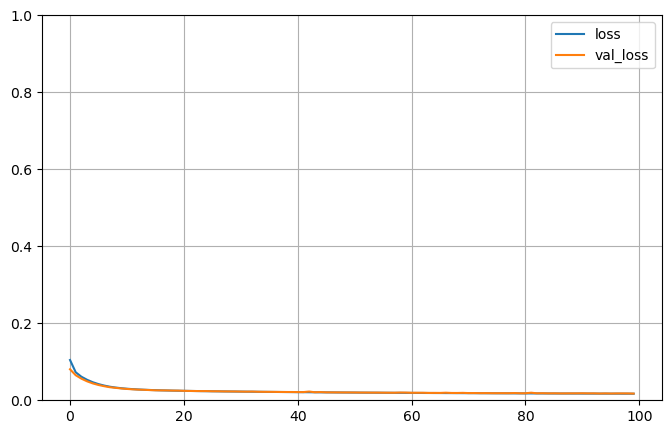

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()
tf.random.set_seed(60)
model = Sequential([
    tf.keras.layers.Dense(52, activation='relu',input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(52, activation='relu',input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-3)
model.compile(loss='mean_absolute_error',optimizer=optimizer)
model.evaluate(x_test,y_test)
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_valid,y_valid),callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
print(model.evaluate(x_test,y_test))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


In [103]:
submission = pd.read_csv(path('data/Xtest.csv'))
submission['hour_11:00:00'] = 0
submission = clean_dataframe(submission)


print(submission.shape)
# y_pred = model.predict(submission)

# Ysample = pd.DataFrame(y_pred, columns=['p0q0'])
# Ysample['p0q0'] = Ysample['p0q0'].apply(lambda x: round(x,3))
# Ysample.index = np.arange(1, len(Ysample) + 1)
# Ysample.to_csv('Ysample.csv')


(13752, 49)


In [116]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

def build_model(n_hidden=1,n_neurons=30,learning_rate=3e-3,input_shape=[49]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons,activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error',optimizer=optimizer)
    return model

# Wrap the model
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

# Different parmeters to try
params = {
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(1,100),
    'learning_rate': reciprocal(3e-4,3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, params, n_iter=10,cv=3)
rnd_search_cv.fit(x_train,y_train,epochs=100,validation_data=(x_valid,y_valid),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])



Epoch 1/100


/var/folders/gv/7n3c64dx2936rpr3757hlbsh0000gn/T/ipykernel_83443/2441655669.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)


389/389 [==============================] - 1s 1ms/step - loss: 0.1194 - val_loss: 0.1000
Epoch 2/100
389/389 [==============================] - 0s 761us/step - loss: 0.0905 - val_loss: 0.0828
Epoch 3/100
389/389 [==============================] - 0s 749us/step - loss: 0.0760 - val_loss: 0.0712
Epoch 4/100
389/389 [==============================] - 0s 738us/step - loss: 0.0661 - val_loss: 0.0631
Epoch 5/100
389/389 [==============================] - 0s 752us/step - loss: 0.0593 - val_loss: 0.0574
Epoch 6/100
389/389 [==============================] - 0s 754us/step - loss: 0.0543 - val_loss: 0.0531
Epoch 7/100
389/389 [==============================] - 0s 743us/step - loss: 0.0507 - val_loss: 0.0500
Epoch 8/100
389/389 [==============================] - 0s 859us/step - loss: 0.0478 - val_loss: 0.0471
Epoch 9/100
389/389 [==============================] - 0s 742us/step - loss: 0.0454 - val_loss: 0.0448
Epoch 10/100
389/389 [==============================] - 0s 737us/step - loss: 0.0434 - 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd2245d33d0>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd2245d2e00>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [117]:
rnd_search_cv.best_params_

{'learning_rate': 0.0027122441336726246, 'n_hidden': 2, 'n_neurons': 52}